In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import cv2
import imageio
import base64
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from google.colab import files


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
!cp /content/drive/MyDrive/AEECS442/Final_Project/imgs.zip imgs.zip
!cp /content/drive/MyDrive/AEECS442/Final_Project/img_classes.zip img_classes.zip

In [6]:
!unzip imgs.zip
!unzip img_classes.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/img_classes/000000154263.png  
  inflating: content/img_classes/000000520553.png  
  inflating: content/img_classes/000000034120.png  
  inflating: content/img_classes/000000203236.png  
  inflating: content/img_classes/000000372618.png  
  inflating: content/img_classes/000000387930.png  
  inflating: content/img_classes/000000288548.png  
  inflating: content/img_classes/000000128557.png  
  inflating: content/img_classes/000000228956.png  
  inflating: content/img_classes/000000069757.png  
  inflating: content/img_classes/000000030871.png  
  inflating: content/img_classes/000000041279.png  
  inflating: content/img_classes/000000265594.png  
  inflating: content/img_classes/000000274736.png  
  inflating: content/img_classes/000000440779.png  
  inflating: content/img_classes/000000227440.png  
  inflating: content/img_classes/000000397942.png  
  inflating: content/img_classes/000000109487.png  
  inflating: 

In [7]:
# Reference: https://stackoverflow.com/questions/13405956/convert-an-image-rgb-lab-with-python
from PIL import ImageCms
srgb_profile = ImageCms.createProfile("sRGB")
lab_profile  = ImageCms.createProfile("LAB")
rgb2lab_transform = ImageCms.buildTransformFromOpenProfiles(srgb_profile, lab_profile, "RGB", "LAB")
lab2rgb_transform = ImageCms.buildTransformFromOpenProfiles(lab_profile, srgb_profile, "LAB", "RGB")

def rgb2lab(img):
  return ImageCms.applyTransform(img, rgb2lab_transform)

def lab2rgb(img):
  return ImageCms.applyTransform(img, lab2rgb_transform)

In [ ]:
#from someone else's github -- https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl
seed = 123
fit = False
SIZE = 256
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names

In [ ]:
### GETTING IMAGE SUBSET ###
idx = 0
counter = 0
testarr = []
while counter < 10000:
  path = paths[idx]
  idx += 1
  # Get image name
  name = path.split("/")[-1]
  name = name.split(".")[0]

  # Make sure image can be opened (some can't, idk why)
  try:
    img = Image.open(path).convert('LAB').resize((256, 256), resample=Image.BICUBIC)
  except:
    print("Failed to open: ", name)
    continue

  # Get image A and B channels
  img_arr = np.array(img).astype(int)

  img_A = img_arr[:,:,1]
  img_B = img_arr[:,:,2]

  # Get A-B class
  img_A_class = img_A // 16
  img_B_class = img_B // 16
  img_class = (img_A_class*16) + img_B_class

  # Save image class
  out_path_class = f"img_classes/{name}.png"
  cv2.imwrite(out_path_class, img_class)

  # Save greyscale image too
  out_path_img = f"imgs/{name}.png"
  cv2.imwrite(out_path_img, img_arr[:,:,0])

  counter += 1
  testarr.append(1)
  if (counter % 100) == 0:
    print((counter // 100), "%")

print("Final len:", len(testarr))

1 %
2 %
3 %
Failed to open:  000000134918
4 %
5 %
6 %
7 %
8 %
Failed to open:  000000518951
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
Failed to open:  000000150354
37 %
38 %
Failed to open:  000000313608
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
Failed to open:  000000093120
49 %
Failed to open:  000000560349
50 %
51 %
52 %
53 %
54 %
55 %
Failed to open:  000000426558
56 %
57 %
58 %
59 %
60 %
61 %
62 %
Failed to open:  000000578250
63 %
64 %
65 %
66 %
67 %
Failed to open:  000000518025
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %
Final len: 10000


In [ ]:
# Save images and image class data for reuse, if necessary
!zip -r /content/imgs.zip /content/imgs
!zip -r /content/img_classes.zip /content/img_classes

!cp imgs.zip /content/drive/MyDrive/AEECS442/Final_Project/
!cp img_classes.zip /content/drive/MyDrive/AEECS442/Final_Project/

Streaming output truncated to the last 5000 lines.
  adding: content/img_classes/000000154263.png (deflated 83%)
  adding: content/img_classes/000000520553.png (deflated 3%)
  adding: content/img_classes/000000034120.png (deflated 2%)
  adding: content/img_classes/000000203236.png (deflated 3%)
  adding: content/img_classes/000000372618.png (deflated 2%)
  adding: content/img_classes/000000387930.png (deflated 3%)
  adding: content/img_classes/000000288548.png (deflated 2%)
  adding: content/img_classes/000000128557.png (deflated 2%)
  adding: content/img_classes/000000228956.png (deflated 1%)
  adding: content/img_classes/000000069757.png (deflated 3%)
  adding: content/img_classes/000000030871.png (deflated 2%)
  adding: content/img_classes/000000041279.png (deflated 5%)
  adding: content/img_classes/000000265594.png (deflated 1%)
  adding: content/img_classes/000000274736.png (deflated 2%)
  adding: content/img_classes/000000440779.png (deflated 3%)
  adding: content/img_classes/000

In [8]:
# Now for model training -- getting indices first
seed = 123
fit = False
SIZE = 256
np.random.seed(seed)

In [9]:
#paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set

In [10]:
# Now getting image paths
img_names = np.array([os.path.basename(path) for path in glob.glob("content/imgs/*.png")])
train_names = img_names[train_idxs]
val_names = img_names[val_idxs]

000000561047.png
000000413676.png
000000272877.png
000000561047.png
000000413676.png
000000272877.png


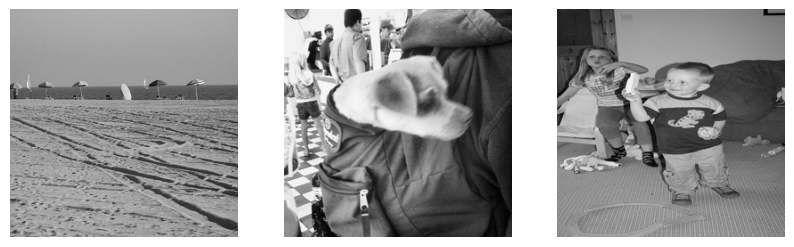

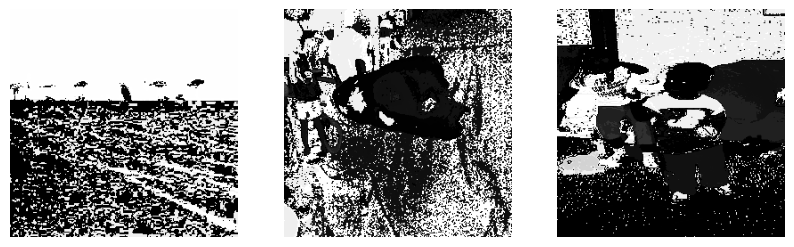

In [11]:
# Making sure paths are working
_, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, img_name in zip(axes.flatten(), train_names):
    ax.imshow(Image.open(f"content/imgs/{img_name}"), cmap='gray')
    print(img_name)
    ax.axis("off")

_, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, img_name in zip(axes.flatten(), train_names):
    ax.imshow(Image.open(f"content/img_classes/{img_name}"), cmap='gray')
    print(img_name)
    ax.axis("off")

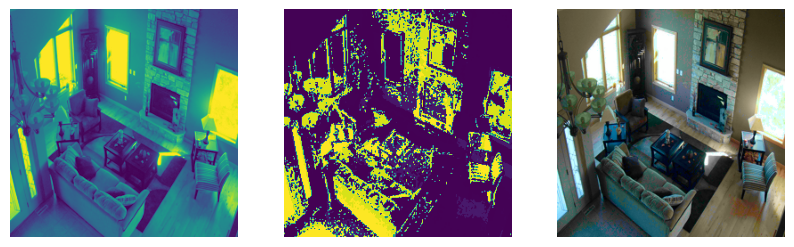

In [12]:
# Visualizing the reconstruction from the image class files
def visualize_classification(img_name):
  img_path = f"content/imgs/{img_name}"
  img_class_path = f"content/img_classes/{img_name}"

  # Get image A and B channels
  img_class = np.array(Image.open(img_class_path)).astype(int)
  img_A = (img_class // 16) * 16
  img_B = (img_class % 16) * 16

  # Get image L channel from original image
  img_L = np.array(Image.open(img_path)).astype(int)

  # Reconstruct image in RGB
  img_recon = np.stack([img_L, img_A, img_B], axis=2).astype("uint8")
  img_recon_rgb = np.array(lab2rgb(Image.fromarray(img_recon, mode="LAB")))

  # Outputting original image and reconstruction
  img = np.array(Image.open(img_path)).astype(int)
  return img, img_class, img_recon_rgb

# Print an example
img, img_class, img_recon_rgb = visualize_classification(img_names[0])
_, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, image in zip(axes.flatten(), [img, img_class, img_recon_rgb]):
    ax.imshow(image)
    ax.axis("off")

In [ ]:
class_counts = np.zeros(256)
count = 0
for name in img_names:
  img_class_path = f"img_classes/{name}"
  img_class = np.array(Image.open(img_class_path)).astype(int).flatten()
  for i in img_class:
    class_counts[i] += 1
  count += 1
  if (count % 100) == 0:
    print(count // 100, "%")

print(class_counts)

1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %
[2.25309778e+08 6.60461800e+07 1.61596910e+07 3.38825700e+06
 7.65227000e+05 9.12420000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00000000e+00 7.43040000e+04
 7.34787000e+05 2.43472300e+06 8.46472700e+06 6.80703210e+07
 1.30946400e+07 2.61171780e+07 1.57822450e+07 4.22245700e+06
 7.80413000e+05 2.06180000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.30970000e+04 1.52327000e+05
 4.18560000e+05 5.54677000e+05 8.25437000e+05 2.52050600e+06
 1.60577700e+06 5.06

In [13]:
class_counts = np.load("class_counts.npy")

In [15]:
np.save("class_counts.npy", class_counts)
class_counts_corrected = ((class_counts + 100000)**(-1/2)) * 10000
print(class_counts_corrected)
np.save("class_counts_corrected.npy", class_counts_corrected)

# This'll be useful for weighting with losses
class_weight_tensor = torch.from_numpy(class_counts_corrected)
class_weight_tensor = torch.unsqueeze(class_weight_tensor, -1)
class_weight_tensor = torch.unsqueeze(class_weight_tensor, -1)
class_weight_tensor = torch.unsqueeze(class_weight_tensor, 0).to(device)

[ 0.66606042  1.22955402  2.47995532  5.35421446 10.75065607 22.86695629
 31.6227766  31.6227766  31.6227766  31.6227766  31.62214417 23.9522504
 10.94490916  6.28108611  3.4169863   1.21116226  2.75296841  1.95302152
  2.5092507   4.80988463 10.65753522 28.7934655  31.6227766  31.6227766
 31.6227766  31.6227766  29.73544604 19.90756479 13.88674604 12.35908896
 10.39504971  6.17742414  7.65665137  4.39989747  4.24268748  6.35171104
 14.30692762 31.60539841 31.6227766  31.6227766  31.6227766  31.52943002
 27.79494045 23.34016263 24.8432829  24.49906262 17.66233204 13.32680776
 13.92101627  8.7781766   6.71328597  9.27276405 20.21084801 31.62246038
 31.6227766  31.6227766  31.6227766  30.90839407 29.75110213 30.40679709
 30.18916933 28.21472303 24.91620444 17.42244888 23.23772347 19.32216543
 13.22864742 12.42191937 22.46759911 31.6227766  31.6227766  31.6227766
 31.61692801 31.46552724 31.60571412 31.55720574 31.191874   30.16951604
 28.72555306 26.12676472 31.01763233 31.18899138 31.13

In [16]:
# The dataloader
# No need for resizing -- the images are already 256x256
class ColorizationDataset(Dataset):
    def __init__(self, file_names, transform=None):
        self.img_paths = np.array([f"content/imgs/{name}" for name in file_names])
        self.img_class_paths = np.array([f"content/img_classes/{name}" for name in file_names])
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        grayscale_img = Image.open(self.img_paths[idx])
        classified_img = Image.open(self.img_class_paths[idx])

        if self.transform:
            grayscale_img = self.transform(grayscale_img) # torch.unsqueeze(torch.as_tensor(np.array(grayscale_img)), 0)
            classified_img = torch.squeeze(self.transform(classified_img)) # torch.as_tensor(np.array(classified_img))
            #classified_img = torch.nn.functional.one_hot(classified_img.to(torch.int64), 256).permute(2, 0, 1).float()

        return grayscale_img, classified_img

# convert to Tensors
transform = transforms.Compose([
    transforms.PILToTensor(),
])

In [17]:
# Create train/val dataset
train_dataset = ColorizationDataset(train_names, transform=transform)
val_dataset = ColorizationDataset(val_names, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [18]:
# Create the classification model
# Input dim: 1x256x256
# Output dim: 256x256x256
class ColorizeWithClassification(nn.Module):
    def __init__(self, num_classes):
        super(ColorizeWithClassification, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.features = nn.Sequential(*list(base_model.children())[:6]) # Switched from -2 to 6

        self.up = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)  # Output num_classes for each pixel
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.up(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        x = self.softmax(x)
        return x

model = ColorizeWithClassification(256).to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


ColorizeWithClassification(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [19]:
# Accessories
optimizer = optim.Adam(model.parameters(), lr=0.001)

# The loss function
def criterion(output, target, num_classes=256):
    # Convert target to one-hot
    target_one_hot = torch.nn.functional.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    # Use cross-entropy loss
    log_prob = torch.log(output + 1e-10)  # add a small number to prevent log(0)
    loss = -torch.sum((target_one_hot * class_weight_tensor) * log_prob) / output.numel()
    return loss

In [50]:
losses = [0.0244, 0.0182, 0.0248, 0.0248, 0.0232, 0.0308, 0.0170, 0.0152, 0.0147, 0.0220]

In [57]:
# Training loop (actually ran for 45 epochs, I just split it due to runtime constraints)
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (grayscale_imgs, classified_imgs) in enumerate(train_loader):
        grayscale_imgs = grayscale_imgs.to(device).to(torch.float)
        classified_imgs = classified_imgs.to(device).to(torch.int64)
        optimizer.zero_grad()
        outputs = model(grayscale_imgs)
        loss = criterion(outputs, classified_imgs)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
          print(batch_idx)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [1/15], Loss: 0.0168
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [2/15], Loss: 0.0211
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [3/15], Loss: 0.0195
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [4/15], Loss: 0.0235
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [5/15], Loss: 0.0261
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [6/15], Loss: 0.0139
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [7/15], Loss: 0.0173
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [8/15], Loss: 0.0191
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
Epoch [9/15], Loss: 0.0207
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800

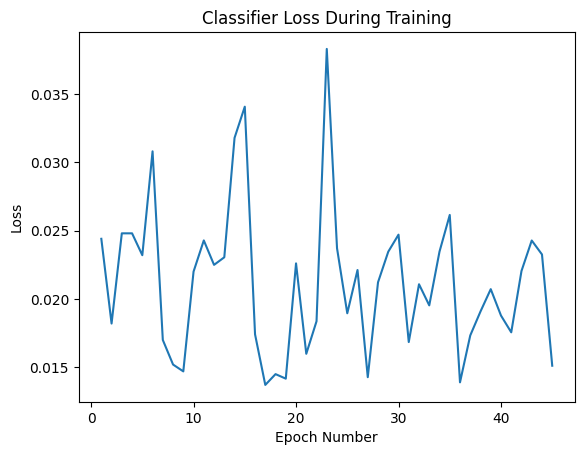

In [87]:
epoch_count_arr = np.arange(1, 46)
plt.plot(epoch_count_arr, losses)
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Classifier Loss During Training")
plt.show()

In [58]:
# Save the current model state
torch.save(model.state_dict(), "testmodel_less_weighted_many_epoch.pth")

In [81]:
# Testing function to get model outputs given an image
def test_model(model, img_name):
  model.eval()
  with torch.no_grad():
    # Get the image the model trained for
    greyscale, _, ground_truth = visualize_classification(img_name)

    img_path = f"content/imgs/{img_name}"
    #img_class_path = f"content/img_classes/{img_name}"

    # Run model
    grayscale_tensor = torch.unsqueeze(transform(Image.open(img_path)).to(device).to(torch.float), 0)
    model_output = torch.squeeze(model(grayscale_tensor))

    # Get predicted A and B channels
    model_output_class = np.array(torch.argmax(model_output, dim=0).cpu())
    img_A = (model_output_class // 16) * 16
    img_B = (model_output_class % 16) * 16

    # Get L channel
    img_L = np.array(Image.open(img_path))

    # Reconstruct image
    img_recon = np.stack([img_L, img_A, img_B], axis=2).astype("uint8")
    img_recon_rgb = np.array(lab2rgb(Image.fromarray(img_recon, mode="LAB")))

  return greyscale, img_recon_rgb, ground_truth

In [67]:
def see_output(model, name):
  grayscale, img_recon_rgb, ground_truth = test_model(model, name) # val_names
  '''
  _, axes = plt.subplots(1, 3, figsize=(10, 10))
  for ax, image in zip(axes.flatten(), [grayscale, img_recon_rgb, ground_truth]):
      ax.imshow(image)
      ax.axis("off")
  '''

  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  axes[0].imshow(grayscale, cmap='gray')
  axes[0].set_title('Grayscale')
  axes[0].axis('off')
  axes[1].imshow(img_recon_rgb)
  axes[1].set_title('Predicted Colorized')
  axes[1].axis('off')
  axes[2].imshow(ground_truth)
  axes[2].set_title('Ground Truth Colorized')
  axes[2].axis('off')
  plt.show()

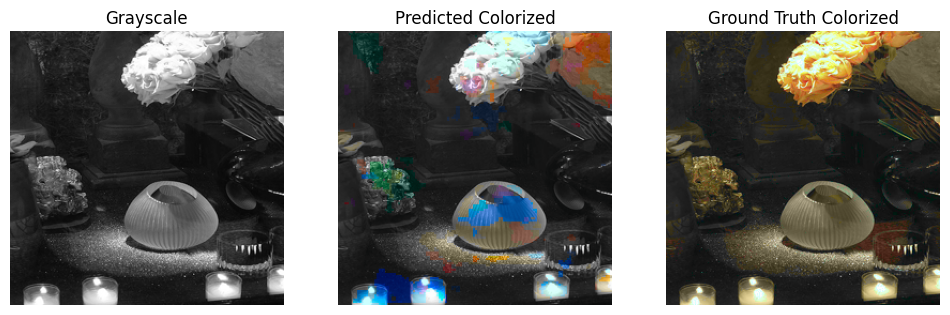

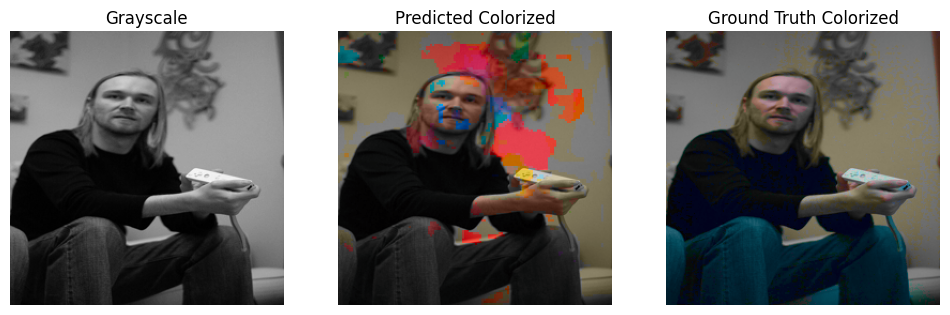

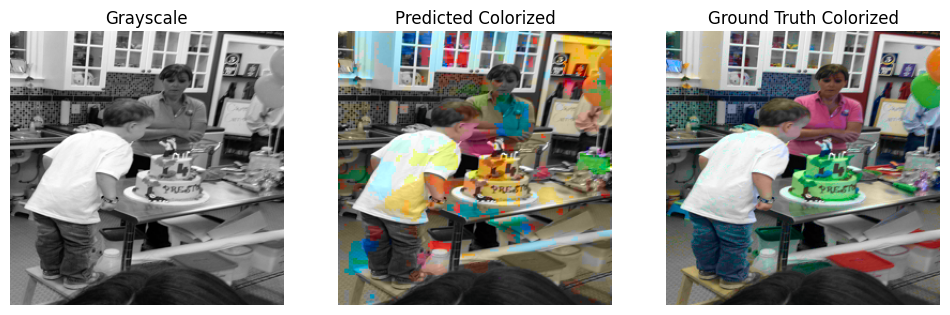

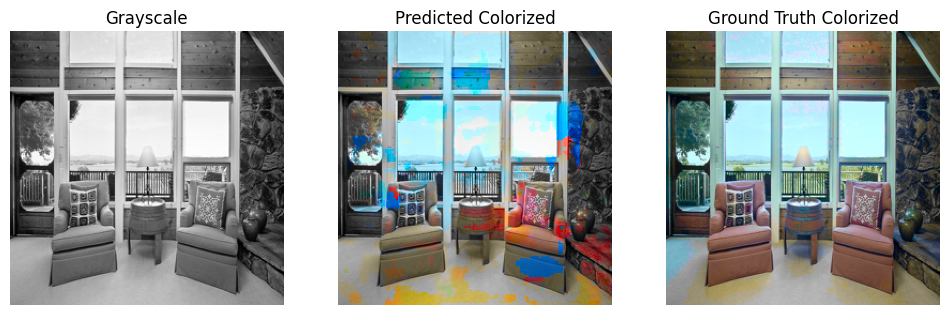

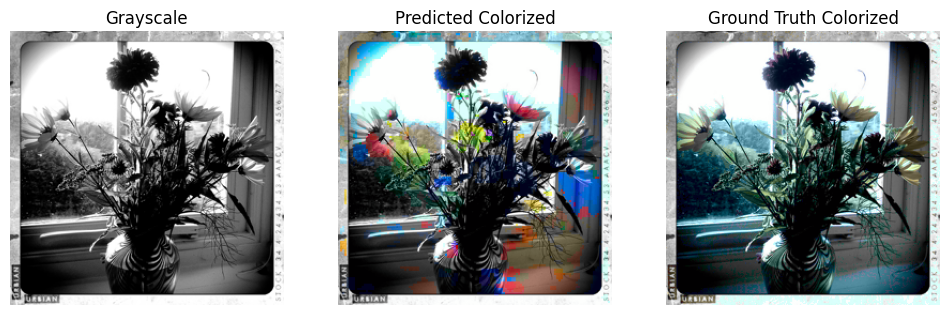

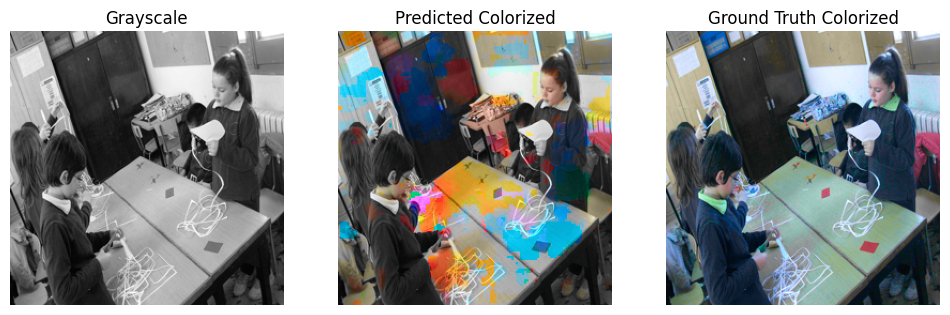

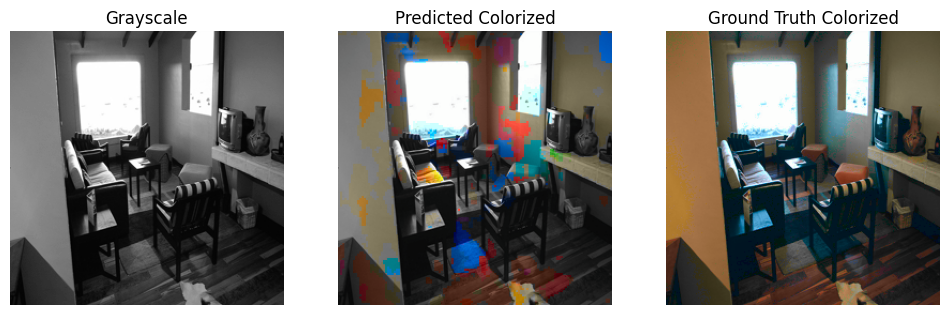

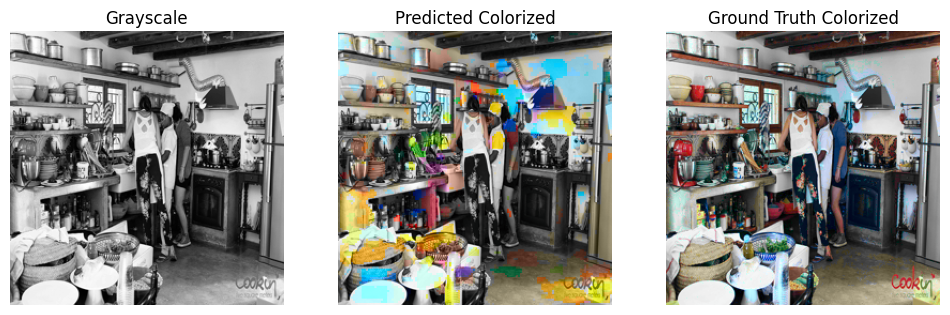

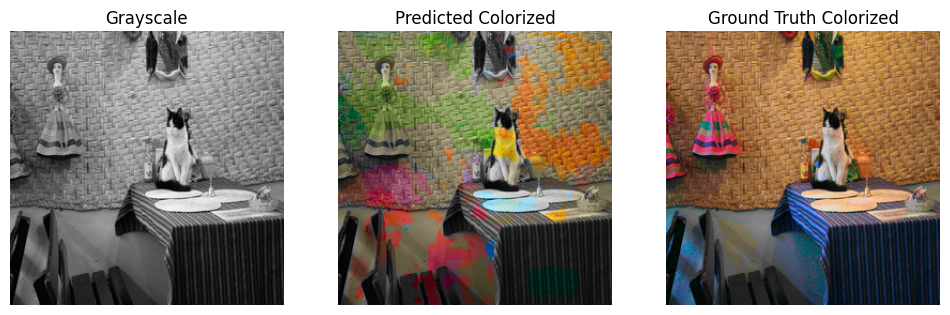

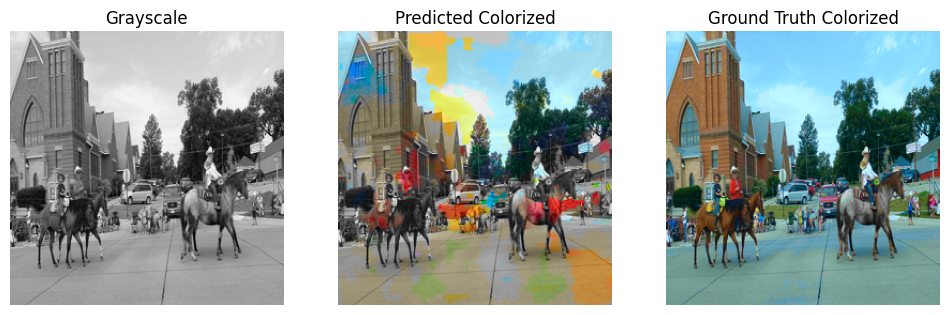

In [82]:
# Print model output
for i in range(10):
  see_output(model, val_names[i])

torch.Size([256, 256, 256])
tensor([2.4347e-03, 1.3131e-03, 9.1524e-04, 3.9538e-03, 5.7033e-02, 7.8503e-01,
        5.4932e-18, 5.8285e-18, 4.5290e-18, 4.9563e-18], device='cuda:0')
tensor([1.3796e-01, 1.1535e-01, 3.6086e-02, 2.6875e-03, 3.9713e-05, 1.0886e-06,
        7.4940e-08, 9.1332e-08, 7.7830e-08, 7.6429e-08], device='cuda:0')
(256, 256)


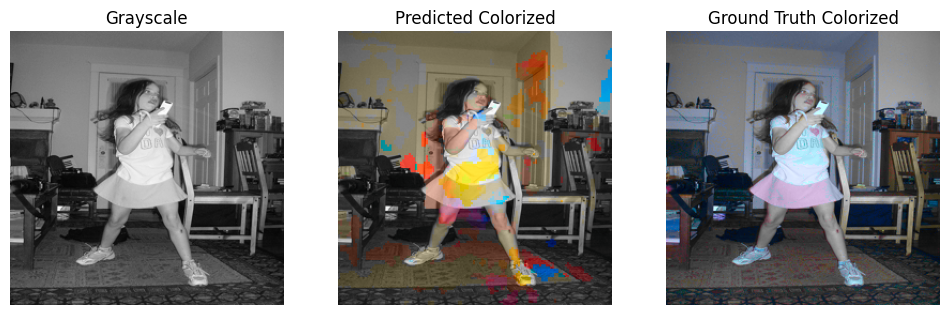

torch.Size([256, 256, 256])
tensor([8.8594e-02, 9.7386e-02, 5.5221e-02, 3.8327e-02, 2.7700e-03, 8.1802e-05,
        2.8624e-09, 3.7183e-09, 3.3299e-09, 3.1329e-09], device='cuda:0')
tensor([2.6765e-01, 3.1561e-02, 1.2924e-02, 5.5416e-03, 1.0239e-03, 7.4123e-05,
        6.6019e-10, 1.2036e-09, 6.4328e-10, 3.1426e-10], device='cuda:0')
(256, 256)


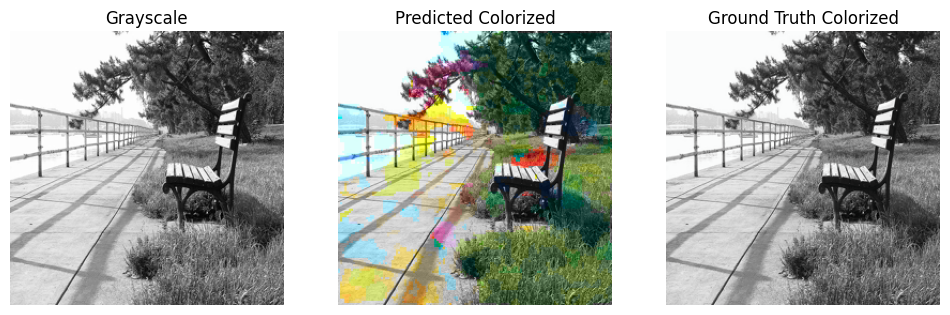

torch.Size([256, 256, 256])
tensor([7.9117e-02, 1.0742e-01, 8.1936e-02, 8.8422e-02, 1.1634e-02, 1.9651e-04,
        3.1474e-10, 4.3110e-10, 3.4033e-10, 4.2139e-10], device='cuda:0')
tensor([1.3315e-01, 1.1946e-01, 6.3883e-02, 3.5802e-02, 5.0839e-03, 7.5506e-05,
        9.9394e-09, 1.3885e-08, 1.2566e-08, 1.2304e-08], device='cuda:0')
(256, 256)


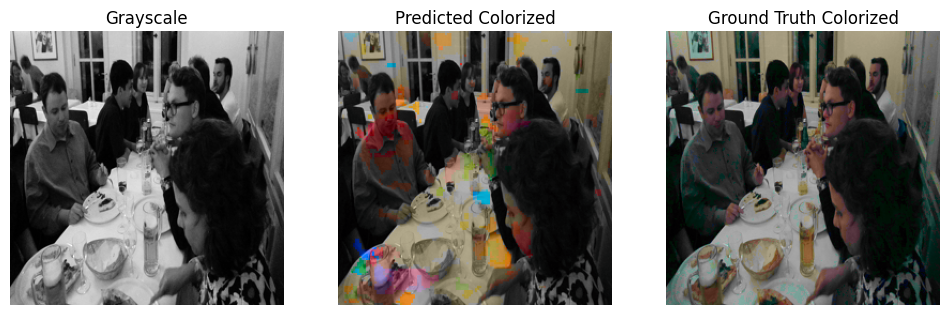

torch.Size([256, 256, 256])
tensor([5.2080e-03, 5.3189e-03, 3.0629e-03, 2.7129e-03, 7.7041e-04, 3.3781e-06,
        1.0168e-11, 5.8409e-12, 6.5541e-12, 8.9289e-12], device='cuda:0')
tensor([1.0402e-01, 9.5664e-02, 3.6371e-02, 9.0645e-03, 2.7720e-04, 7.6481e-06,
        9.2321e-08, 1.2314e-07, 9.1293e-08, 8.5400e-08], device='cuda:0')
(256, 256)


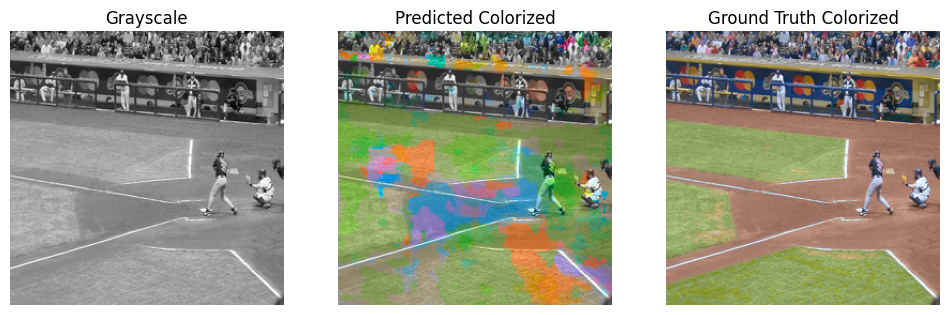

In [77]:
# Some of the better outputs, cherry-picked
see_output(model, val_names[21])
see_output(model, val_names[29])
see_output(model, val_names[38])
see_output(model, val_names[70])